In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

In [14]:
# Menghindari error pada file gambar yang rusak
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [15]:
# Parameter
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20
num_classes = None  # Akan diatur berdasarkan data

In [16]:
# Fungsi untuk preprocessing gambar
def preprocess_image(image_path):
    image = load_img(image_path, target_size=input_shape[:2])
    image = image.convert("RGB")  # Pastikan gambar dalam format RGB
    image = img_to_array(image) / 255.0  # Normalisasi
    return image

In [17]:
class CustomImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, input_shape, subset="training", shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.subset = subset
        self.shuffle = shuffle
        self.file_paths = []
        self.labels = []

        # Memuat daftar gambar dan label
        class_names = sorted(os.listdir(self.directory))
        self.class_indices = {class_name: index for index, class_name in enumerate(class_names)}
        
        # Memuat file path dan label-nya
        for class_name in class_names:
            class_path = os.path.join(self.directory, class_name)
            if os.path.isdir(class_path):
                for file_name in os.listdir(class_path):
                    if file_name.endswith(('jpeg', 'png', 'jpg')):
                        self.file_paths.append(os.path.join(class_path, file_name))
                        self.labels.append(self.class_indices[class_name])

        self.indexes = np.arange(len(self.file_paths))
        self.samples = len(self.file_paths)  # Menambahkan atribut samples
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.file_paths[k] for k in batch_indexes]
        batch_images = np.array([preprocess_image(path) for path in batch_paths])
        batch_labels = np.array([self.labels[k] for k in batch_indexes])
        return batch_images, tf.keras.utils.to_categorical(batch_labels, num_classes=len(self.class_indices))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [18]:
# Data Generator dengan preprocessing manual
train_generator = CustomImageGenerator("./preprocessed_data_makanan", batch_size=batch_size, input_shape=input_shape, subset="training")
val_generator = CustomImageGenerator("./preprocessed_data_makanan", batch_size=batch_size, input_shape=input_shape, subset="validation")


In [19]:
# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Sesuaikan jumlah kelas
])

In [20]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
# Callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.01)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_delta=0.01)
model_checkpoint = ModelCheckpoint("111best_model.h5", save_best_only=True)

In [22]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/20
386/386 [==============================] - 85s 209ms/step - loss: 4.9155 - accuracy: 0.0129 - val_loss: 4.6585 - val_accuracy: 0.0390 - lr: 0.0010
Epoch 2/20
386/386 [==============================] - 79s 206ms/step - loss: 4.5442 - accuracy: 0.0433 - val_loss: 4.2141 - val_accuracy: 0.0857 - lr: 0.0010
Epoch 3/20
386/386 [==============================] - 77s 201ms/step - loss: 4.1845 - accuracy: 0.0810 - val_loss: 3.6374 - val_accuracy: 0.1989 - lr: 0.0010
Epoch 4/20
386/386 [==============================] - 78s 201ms/step - loss: 3.7347 - accuracy: 0.1459 - val_loss: 3.0197 - val_accuracy: 0.3330 - lr: 0.0010
Epoch 5/20
386/386 [==============================] - 85s 221ms/step - loss: 3.2796 - accuracy: 0.2284 - val_loss: 2.3594 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 6/20
386/386 [==============================] - 79s 205ms/step - loss: 2.8033 - accuracy: 0.3171 - val_loss: 1.8624 - val_accuracy: 0.5959 - lr: 0.0010
Epoch 7/20
386/386 [==============================] 

In [23]:
# Evaluasi dengan data uji
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


NameError: name 'test_generator' is not defined

In [24]:
fine_tune_lr = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=fine_tune_lr, loss="categorical_crossentropy", metrics=["accuracy"])

history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  # Fine-tuning tambahan
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
386/386 [==============================] - 76s 196ms/step - loss: 0.3638 - accuracy: 0.8888 - val_loss: 0.0154 - val_accuracy: 0.9974 - lr: 1.0000e-04
Epoch 2/10
386/386 [==============================] - 83s 215ms/step - loss: 0.3137 - accuracy: 0.9023 - val_loss: 0.0133 - val_accuracy: 0.9975 - lr: 1.0000e-04
Epoch 3/10
386/386 [==============================] - 81s 211ms/step - loss: 0.3025 - accuracy: 0.9072 - val_loss: 0.0118 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 4/10
386/386 [==============================] - 84s 218ms/step - loss: 0.2653 - accuracy: 0.9174 - val_loss: 0.0106 - val_accuracy: 0.9981 - lr: 1.0000e-04
Epoch 5/10
386/386 [==============================] - 82s 213ms/step - loss: 0.2632 - accuracy: 0.9173 - val_loss: 0.0105 - val_accuracy: 0.9979 - lr: 1.0000e-05
Epoch 6/10
386/386 [==============================] - 78s 202ms/step - loss: 0.2653 - accuracy: 0.9166 - val_loss: 0.0105 - val_accuracy: 0.9979 - lr: 1.0000e-05


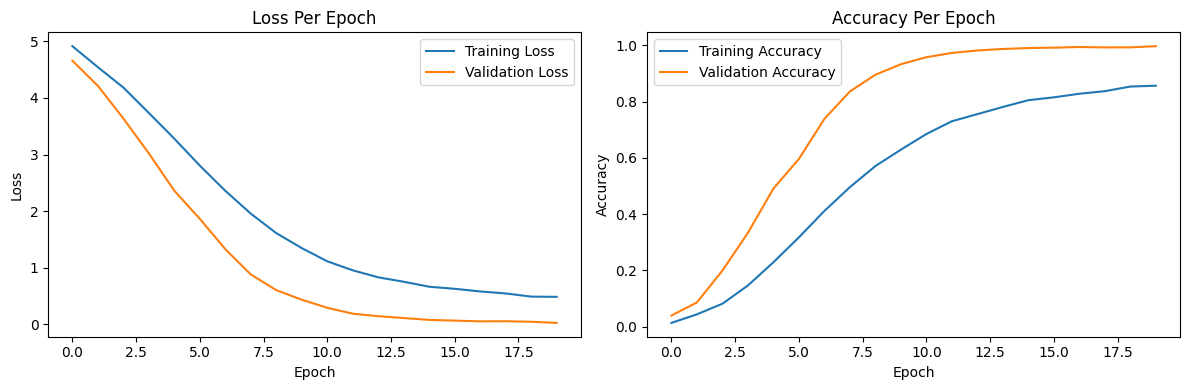

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
model.save('mymodel.h5')  # Save in HDF5 format

In [38]:

# Fungsi untuk prediksi gambar
def predict_image(model, image_path, class_indices):
    image = preprocess_image(image_path)
    if image is None:
        print("Gagal memproses gambar.")
        return None

    image = np.expand_dims(image, axis=0)  # Tambahkan batch dimension
    predictions = model.predict(image)
    predicted_index = np.argmax(predictions)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_label = class_labels[predicted_index]
    print(f"Prediksi: {predicted_label} ({predictions[0][predicted_index]*100:.2f}%)")
    return predicted_label

# Contoh prediksi
test_image_path = "./coto.jpeg"  # Ubah ke path gambar Anda
predict_image(model, test_image_path, train_generator.class_indices)

1/1 [==============================] - 0s 21ms/step
Prediksi: serabi_solo (41.11%)


'serabi_solo'